Objetivo: Preparar o dataset para o treinamento do modelo de classificação de cacau

Materiais: Dataset com amostras de diferentes usos do solo. 

Fonte dos dados e exemplos:

1) https://www.youtube.com/watch?v=0W6MKZqSke8&t=1631s

2) https://github.com/bnsreenu/python_for_microscopists/tree/master/230_landcover_dataset_segmentation


3) Imagens primeira rodada de testes: https://landcover.ai.linuxpolska.com/





In [1]:

import os
import cv2
import numpy as np
import glob
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
#import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random


2023-03-10 15:09:04.863458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 15:09:04.977807: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-10 15:09:04.980323: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/luismellow/Data_science_proj/geo_env/lib/python3.10/site-packages/cv2/../../l

In [2]:

os.chdir('/media/luismellow/Seagate Expansion Drive/Louis  work/02_Solidaridad_network/unet_cacau/')

Image name:  N-33-130-A-d-4-4.tif
Mask name:  N-33-130-A-d-4-4.tif


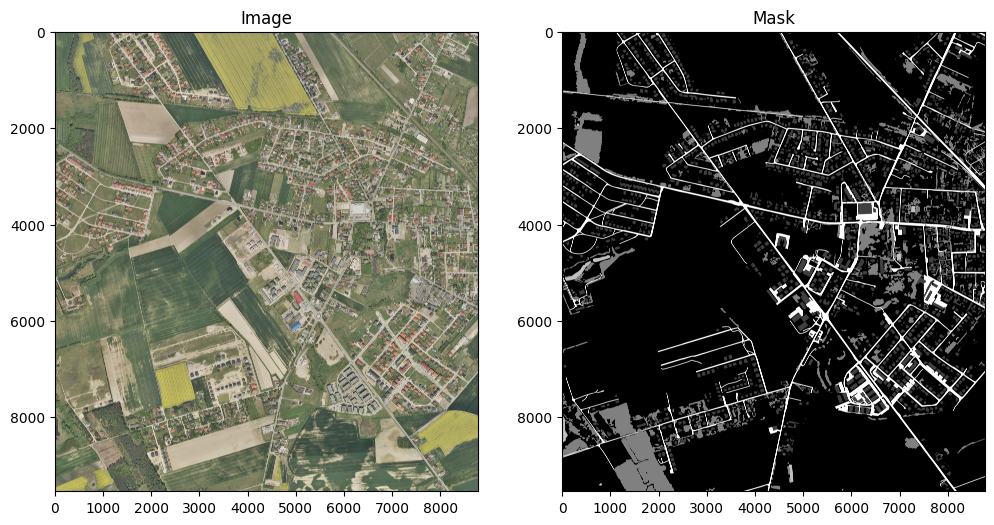

In [14]:
#Primeira parte: Visualizar as imagens do banco de dados
#Objetivo: Checar se as imagens e máscaras estão no mesmo formato e se estão alinhadas
train_img_dir = "data/images_2/"
train_mask_dir = "data/masks_2/"

#Listando arquivos de imagens e máscaras no diretório
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

#Selecionando uma imagem aleatória
img_num = random.randint(0, num_images-1)
img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

#Printing the name of the image and mask used for plotting
print('Image name: ', img_list[img_num])
print('Mask name: ', msk_list[img_num])

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [15]:
#Read images from 'images' subdirectory
#As all images are of different size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 

#Now, crop each large image into patches of 256x256. Save them into a directory 
#so we can use data augmentation and read directly from the drive. 

#Teste 01 - 9 imagens em cada dataset, mask e image
#~13 minutos o tempo total de execução
root_directory = 'data/'

patch_size = 256

img_dir=root_directory+"images_2/"
for path, subdirs, files in os.walk(img_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    #print(dirname)
    images = os.listdir(path)  #List of all image names in this subdirectory
    #print(images)
    for i, image_name in enumerate(images):  
        if image_name.endswith(".tif"):
            print(image_name)
            image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
            SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            
            #Abrindo a imagem a partir de um numpy array e recortando
            image = Image.fromarray(image)
            image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            
            #Salvando a imagem em um numpy array
            image = np.array(image)             
   
            #Extract patches from each image
            print("Partindo imagem em imagens menores:", path+"/"+image_name)
            patches_img = patchify(image, (256, 256, 3), step=256)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    
                    single_patch_img = patches_img[i,j,:,:]
                    single_patch_img = (single_patch_img.astype('float32')) / 255. #We will preprocess using one of the backbones
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                    
                    cv2.imwrite(root_directory+"256_patches/images/"+
                               image_name+"patch_"+str(i)+str(j)+".tif", single_patch_img)
                    #image_dataset.append(single_patch_img)
            print('Todas as imagens foram salvas com sucesso!')        
  
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dir=root_directory+"masks_2/"
for path, subdirs, files in os.walk(mask_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]

    masks = os.listdir(path)  #List of all image names in this subdirectory
    for i, mask_name in enumerate(masks):  
        if mask_name.endswith(".tif"):           
            mask = cv2.imread(path+"/"+mask_name, 0)  #Read each image as Grey (or color but remember to map each color to an integer)
            SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            mask = Image.fromarray(mask)
            mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            mask = np.array(mask)             
   
            #Extract patches from each image
            print("Partindo máscaras em imagens menores:", path+"/"+mask_name)
            patches_mask = patchify(mask, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    
                    single_patch_mask = patches_mask[i,j,:,:]
                    single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                    single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                    cv2.imwrite(root_directory+"256_patches/masks/"+
                               mask_name+"patch_"+str(i)+str(j)+".tif", single_patch_mask)
            print('Todas as máscaras foram salvas com sucesso!')


N-33-104-A-c-1-1.tif
Partindo imagem em imagens menores: data/images_2//N-33-104-A-c-1-1.tif
N-33-119-C-c-3-3.tif
Partindo imagem em imagens menores: data/images_2//N-33-119-C-c-3-3.tif
N-33-130-A-d-3-3.tif
Partindo imagem em imagens menores: data/images_2//N-33-130-A-d-3-3.tif
N-33-130-A-d-4-4.tif
Partindo imagem em imagens menores: data/images_2//N-33-130-A-d-4-4.tif
N-33-139-C-d-2-2.tif
Partindo imagem em imagens menores: data/images_2//N-33-139-C-d-2-2.tif
N-33-139-C-d-2-4.tif
Partindo imagem em imagens menores: data/images_2//N-33-139-C-d-2-4.tif
N-33-139-D-c-1-3.tif
Partindo imagem em imagens menores: data/images_2//N-33-139-D-c-1-3.tif
N-33-60-D-d-1-2.tif
Partindo imagem em imagens menores: data/images_2//N-33-60-D-d-1-2.tif
N-33-96-D-d-1-1.tif
Partindo imagem em imagens menores: data/images_2//N-33-96-D-d-1-1.tif
Partindo imagem em imagens menores: data/masks_2//N-33-104-A-c-1-1.tif
Partindo imagem em imagens menores: data/masks_2//N-33-119-C-c-3-3.tif
Partindo imagem em imagen

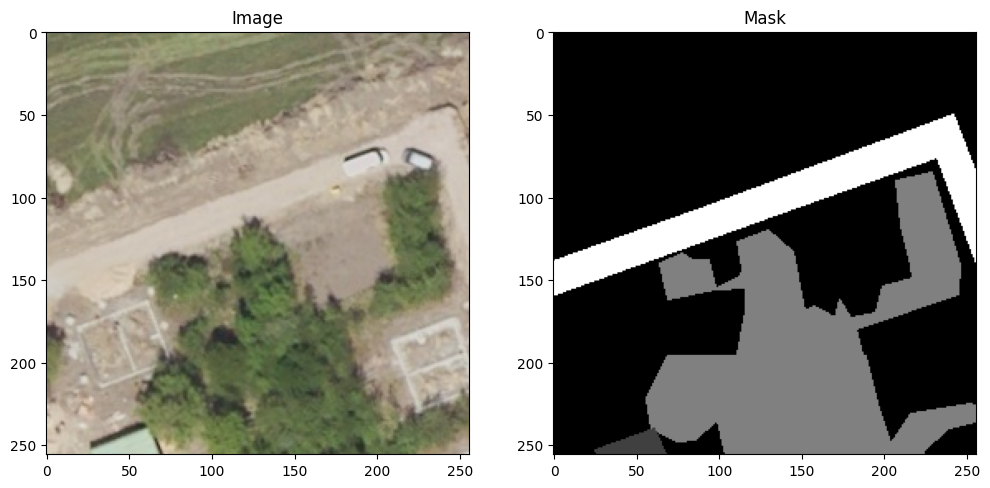

In [28]:
train_img_dir = "data/256_patches/images/"
train_mask_dir = "data/256_patches/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))
img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [31]:
###########################################################################

#Now, let us copy images and masks with real information to a new folder.
# real information = if mask has decent amount of labels other than 0. 

#Teste 01 - 9 imagens em cada dataset, mask e image
#Tempo de execução: 13 minutos de total de tempo para executar o código

useless=0  #Useless image counter
for img in range(len(img_list)):   #Using t1_list as all lists are of same size
    img_name=img_list[img]
    mask_name = msk_list[img]
    print("Now preparing image and masks number: ", img)
      
    temp_image=cv2.imread(train_img_dir+img_list[img], 1)
   
    temp_mask=cv2.imread(train_mask_dir+msk_list[img], 0)
    #temp_mask=temp_mask.astype(np.uint8)
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.05:  #At least 5% useful area with labels that are not 0
        print("Salvando imagem e mascara: ", img_name, mask_name)
        cv2.imwrite('data/256_patches/images_with_useful_info/images/'+img_name, temp_image)
        cv2.imwrite('data/256_patches/images_with_useful_info/masks/'+mask_name, temp_mask)
        
    else:
        print("Esta imagem é inutil para esta análise pois não possui as classes amostradas")   
        useless +=1

print("Total useful images are: ", len(img_list)-useless) 
print("Total useless images are: ", useless) 


Now preparing image and masks number:  0
Esta imagem é inutil para esta análise pois não possui as classes amostradas
Now preparing image and masks number:  1
Salvando imagem e mascara:  N-33-104-A-c-1-1.tifpatch_00.tif N-33-104-A-c-1-1.tifpatch_00.tif
Now preparing image and masks number:  2
Salvando imagem e mascara:  N-33-104-A-c-1-1.tifpatch_01.tif N-33-104-A-c-1-1.tifpatch_01.tif
Now preparing image and masks number:  3
Salvando imagem e mascara:  N-33-104-A-c-1-1.tifpatch_010.tif N-33-104-A-c-1-1.tifpatch_010.tif
Now preparing image and masks number:  4
Salvando imagem e mascara:  N-33-104-A-c-1-1.tifpatch_011.tif N-33-104-A-c-1-1.tifpatch_011.tif
Now preparing image and masks number:  5
Salvando imagem e mascara:  N-33-104-A-c-1-1.tifpatch_012.tif N-33-104-A-c-1-1.tifpatch_012.tif
Now preparing image and masks number:  6
Salvando imagem e mascara:  N-33-104-A-c-1-1.tifpatch_013.tif N-33-104-A-c-1-1.tifpatch_013.tif
Now preparing image and masks number:  7
Salvando imagem e masca

In [32]:
###############################################################
#Now split the data into training, validation and testing. 

"""
Code for splitting folder into train, test, and val.
Once the new folders are created rename them and arrange in the format below to be used
for semantic segmentation using data generators. 
pip install split-folders
"""
import splitfolders  # or import split_folders

input_folder = 'data/256_patches/images_with_useful_info/'
output_folder = 'data/data_for_training_and_testing/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder,
                   seed=42,
                   ratio=(.75, .25),
                   group_prefix=None) # default values

Copying files: 7920 files [00:42, 185.94 files/s]
